# Introduction a PyTorch

Based on https://github.com/mila-udem/welcome_tutorials/tree/master/pytorch By Sandeep Subramanian, https://github.com/jcjohnson/pytorch-examples by Justin Johnson and official documentation http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html .

## Tensor

Tensors are similar to numpy array, but they can also be used on GPUs.

In [1]:
import torch
import numpy as np
from torch.autograd import Variable
# convert numpy array to tensor
torch.from_numpy(np.array([1,2,3,4]))  # LongTensor


 1
 2
 3
 4
[torch.LongTensor of size 4]

In [2]:
torch.from_numpy(np.array([1.,2,3,4]))  # Double Tensor


 1
 2
 3
 4
[torch.DoubleTensor of size 4]

In [3]:
torch.FloatTensor([1,2,3,4])
torch.Tensor([1,2,3,4])  # float tensor by default, can change it with torch.set_default_tensor_type('torch.FloatTensor')


 1
 2
 3
 4
[torch.FloatTensor of size 4]

In [4]:
x = torch.Tensor([1,2,3,4])

In [5]:
x.sqrt()  # similar functionality as numpy


 1.0000
 1.4142
 1.7321
 2.0000
[torch.FloatTensor of size 4]

In [6]:
x = x.view(-1, 1)  # the torch reshape function
print(x.size())

torch.Size([4, 1])


In [7]:
torch.cat([x, x], 1)  # concatenate 2 vectors


 1  1
 2  2
 3  3
 4  4
[torch.FloatTensor of size 4x2]

## Autograd

Autograd provides automatic differentiation on all operations perform on tensors. To be able to use Autograd, you must wrap your tensors in a Variable.

In [8]:
x = Variable(x, requires_grad=False)
w = Variable(torch.ones(4, 1), requires_grad=True)
w

Variable containing:
 1
 1
 1
 1
[torch.FloatTensor of size 4x1]

In [9]:
print(w.grad)

None


In [10]:
z = torch.dot(w, x)
print(z)

Variable containing:
 10
[torch.FloatTensor of size 1]



## Optim and loss function

In [11]:
optimizer = torch.optim.SGD([w], lr=0.01)

In [12]:
optimizer.zero_grad()
z.backward()
print(w.grad)
optimizer.step()

Variable containing:
 1
 2
 3
 4
[torch.FloatTensor of size 4x1]



In [13]:
print(w)

Variable containing:
 0.9900
 0.9800
 0.9700
 0.9600
[torch.FloatTensor of size 4x1]



In [14]:
loss_fn = torch.nn.MSELoss()
z = torch.dot(w, x)
target = Variable(torch.zeros(1))
optimizer.zero_grad()
loss = loss_fn(z, target)
loss.backward()  # retain_graph=True, if you need to call loss.backward() again without optimizer.step()
optimizer.step()
print(w)

Variable containing:
 0.7960
 0.5920
 0.3880
 0.1840
[torch.FloatTensor of size 4x1]



# Fashion MNIST

based on MNIST tutorial: https://github.com/pytorch/examples/blob/master/mnist/main.py

In [15]:
%matplotlib inline  
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torchvision
import torch.nn.functional as F
from fashion import FashionMNIST
import torchvision.transforms as transforms
from torch import nn
from torch import optim

In [16]:
train_data = FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [17]:
train_idx = np.random.choice(train_data.train_data.shape[0], 54000, replace=False)

In [18]:
train_data.train_data = train_data.train_data[train_idx, :]
train_data.train_labels = train_data.train_labels[torch.from_numpy(train_idx).type(torch.LongTensor)]

In [19]:
mask = np.ones(60000)
mask[train_idx] = 0

In [20]:
valid_data.train_data = valid_data.train_data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.train_labels = valid_data.train_labels[torch.from_numpy(mask).type(torch.ByteTensor)]

In [21]:
batch_size = 100
test_batch_size = 100

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)


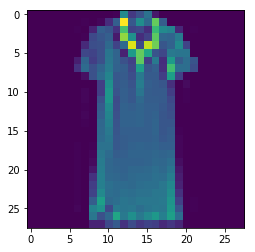

In [22]:
plt.imshow(train_loader.dataset.train_data[1].numpy())

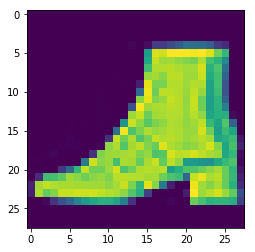

In [23]:
plt.imshow(train_loader.dataset.train_data[10].numpy())

In [24]:
class FcNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = F.sigmoid(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x    

In [25]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)  # calls the forward function
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    return model


def valid(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        # data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    valid_loss /= len(valid_loader.dataset)
    print('\n' + "valid" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return correct / len(valid_loader.dataset)

    
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\n' + "test" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
def experiment(model, epochs=10, lr=0.001):
    best_precision = 0
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        model = train(model, train_loader, optimizer)
        precision = valid(model, valid_loader)
    
        if precision > best_precision:
            best_precision = precision
            best_model = model
    return best_model, best_precision

    

In [26]:
best_precision = 0
for model in [FcNetwork()]:  # add your models in the list
    # model.cuda()  # if you have access to a gpu
    model, precision = experiment(model)
    if precision > best_precision:
        best_precision = precision
        best_model = model

test(best_model, test_loader)


valid set: Average loss: 0.4312, Accuracy: 5090/6000 (85%)


valid set: Average loss: 0.3640, Accuracy: 5224/6000 (87%)


valid set: Average loss: 0.3484, Accuracy: 5285/6000 (88%)


valid set: Average loss: 0.3287, Accuracy: 5289/6000 (88%)


valid set: Average loss: 0.3343, Accuracy: 5273/6000 (88%)


valid set: Average loss: 0.3293, Accuracy: 5276/6000 (88%)


valid set: Average loss: 0.3104, Accuracy: 5323/6000 (89%)


valid set: Average loss: 0.3229, Accuracy: 5323/6000 (89%)


valid set: Average loss: 0.3085, Accuracy: 5332/6000 (89%)


valid set: Average loss: 0.3052, Accuracy: 5357/6000 (89%)


valid set: Average loss: 0.4538, Accuracy: 5001/6000 (83%)


valid set: Average loss: 0.3728, Accuracy: 5207/6000 (87%)


valid set: Average loss: 0.3649, Accuracy: 5220/6000 (87%)


valid set: Average loss: 0.3309, Accuracy: 5281/6000 (88%)


valid set: Average loss: 0.3304, Accuracy: 5279/6000 (88%)


valid set: Average loss: 0.3215, Accuracy: 5278/6000 (88%)


valid set: Average loss